# Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud

# Load dataset

In [2]:
data = pd.read_csv("/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")

In [3]:
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# 0 - REAL
# 1 - FAKE

# Function to plot model Training

In [4]:

def plot_graph(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  

    # Plot training & validation accuracy values
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Data Cleaning

In [5]:
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
# Drop columns with too many missing values and unnecessary columns
data.drop(columns=['salary_range'], inplace=True)
data.drop(columns=['job_id'], inplace=True)


In [7]:
# Fill missing values with 'Unknown'
data['department']=data['department'].fillna('Unknown')
data['company_profile']=data['company_profile'].fillna('No profile available')
data['requirements']=data['requirements'].fillna('No requirements listed')
data['benefits']=data['benefits'].fillna('No benefits listed')
data['required_experience']=data['required_experience'].fillna('Not Applicable')
data['required_education']=data['required_education'].fillna('Unspecified')
data['location']=data['location'].fillna('Unknown')
data['employment_type'] = data['employment_type'].fillna(data['employment_type'].mode()[0])
data['industry'] = data['industry'].fillna('Unknown')
data['function'] = data['function'].fillna('Unknown')

In [8]:
# Drop the rows with no description
data = data.dropna(axis='rows')

In [9]:
data.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [10]:
data.head(3)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,No benefits listed,0,1,0,Other,Internship,Unspecified,Unknown,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,No benefits listed,0,1,0,Full-time,Not Applicable,Unspecified,Unknown,Unknown,0


In [11]:
data['text'] = data.apply(lambda row: ' '.join(row[['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']].astype(str)), axis=1)


In [12]:
data.drop(columns=['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'], inplace=True)


In [13]:
data.head(3)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,1,0,Other,Internship,Unspecified,Unknown,Marketing,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,Full-time,Not Applicable,Unspecified,Unknown,Unknown,0,"Commissioning Machinery Assistant (CMA) US, IA..."


In [14]:
# Save a copy of data for EDA
data_original = data.copy()


In [15]:
# Convert string values in Categorical columns to int values
from sklearn.preprocessing import LabelEncoder

le_employment_type = LabelEncoder()
le_required_experience = LabelEncoder()
le_required_education = LabelEncoder()
le_industry = LabelEncoder()
le_function = LabelEncoder()


In [16]:
data['employment_type'] = le_employment_type.fit_transform(data['employment_type'])
data['required_experience'] = le_required_experience.fit_transform(data['required_experience'])
data['required_education'] = le_required_education.fit_transform(data['required_education'])
data['industry'] = le_industry.fit_transform(data['industry'])
data['function'] = le_function.fit_transform(data['function'])


In [17]:
data.head(3)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,1,0,2,4,9,123,22,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,1,0,1,6,9,75,7,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,1,6,9,123,36,0,"Commissioning Machinery Assistant (CMA) US, IA..."


# EDA

In [18]:
data_original.head(1)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,1,0,Other,Internship,Unspecified,Unknown,Marketing,0,"Marketing Intern US, NY, New York Marketing We..."


In [19]:
# Get basic information about the dataframe
data_original.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17879 entries, 0 to 17879
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   telecommuting        17879 non-null  int64 
 1   has_company_logo     17879 non-null  int64 
 2   has_questions        17879 non-null  int64 
 3   employment_type      17879 non-null  object
 4   required_experience  17879 non-null  object
 5   required_education   17879 non-null  object
 6   industry             17879 non-null  object
 7   function             17879 non-null  object
 8   fraudulent           17879 non-null  int64 
 9   text                 17879 non-null  object
dtypes: int64(4), object(6)
memory usage: 1.5+ MB


In [20]:

# Get summary statistics for numerical columns
data_original.describe()


,telecommuting,has_company_logo,has_questions,fraudulent
count,17879.000000,17879.000000,17879.000000,17879.000000
mean,0.042899,0.795346,0.491750,0.048381
std,0.202636,0.403459,0.499946,0.214576
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


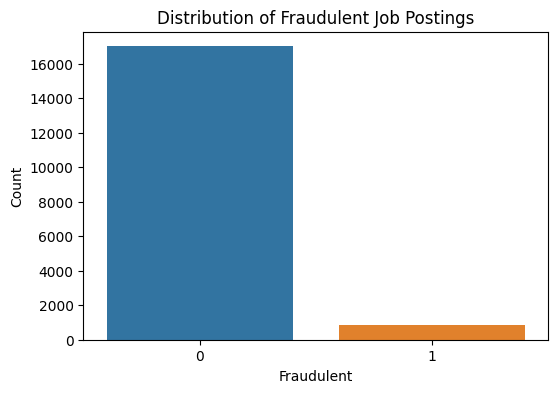

Value Counts of Fraudulent:
 fraudulent
0    17014
1      865
Name: count, dtype: int64


In [21]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=data_original)
plt.title('Distribution of Fraudulent Job Postings')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.show()

print("Value Counts of Fraudulent:\n", data_original['fraudulent'].value_counts())


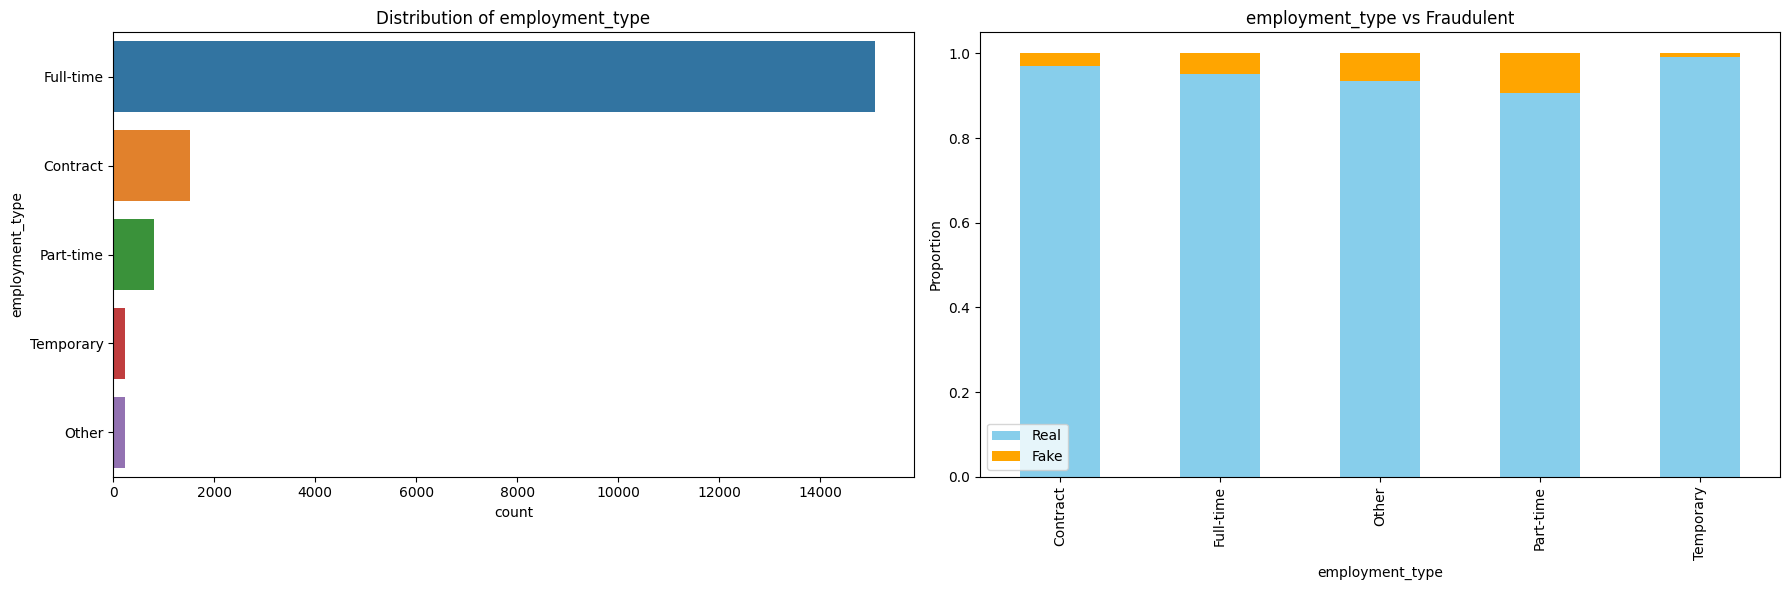

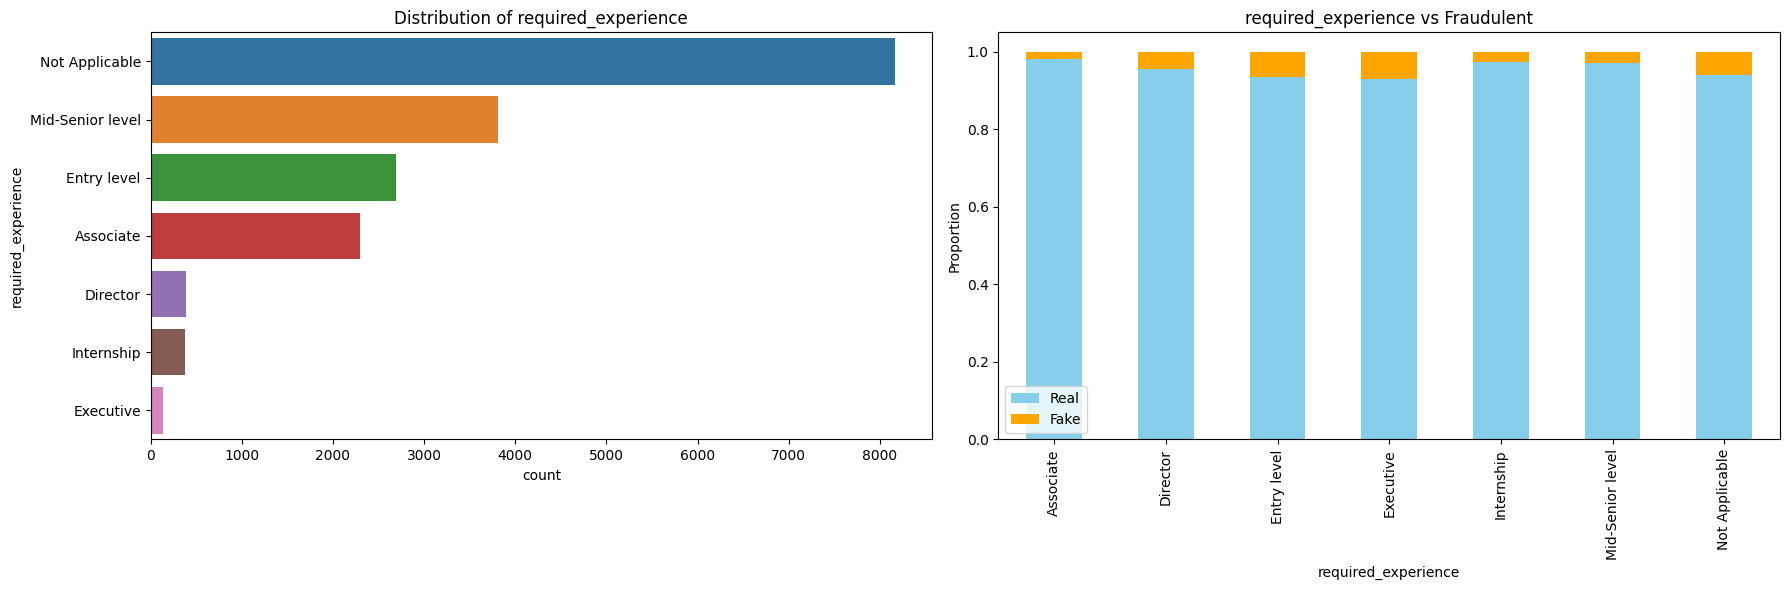

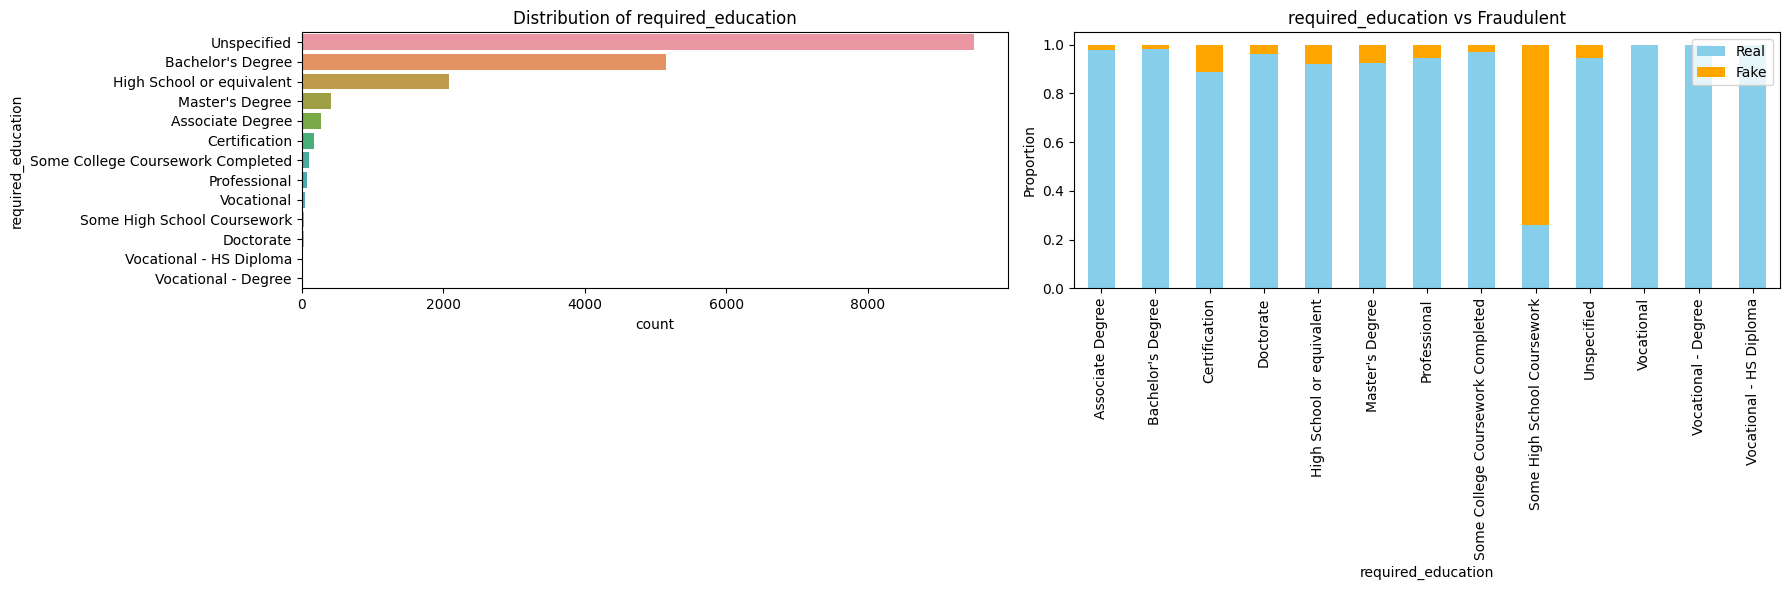

In [ ]:
# Plot the distribution of categorical features
categorical_features = ['employment_type', 'required_experience', 'required_education', 'function']


for feature in categorical_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    
    sns.countplot(y=feature, data=data_original, order=data_original[feature].value_counts().index, ax=axes[0])
    axes[0].set_title(f'Distribution of {feature}')
    
    cross_tab = pd.crosstab(data_original[feature], data_original['fraudulent'])
    cross_tab_ratio = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)
    cross_tab_ratio.plot(kind='bar', stacked=True, ax=axes[1], color=['skyblue', 'orange'])
    
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles, ['Real', 'Fake'])
    
    axes[1].set_title(f'{feature} vs Fraudulent')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel('Proportion')
    
    plt.tight_layout()
    plt.show()


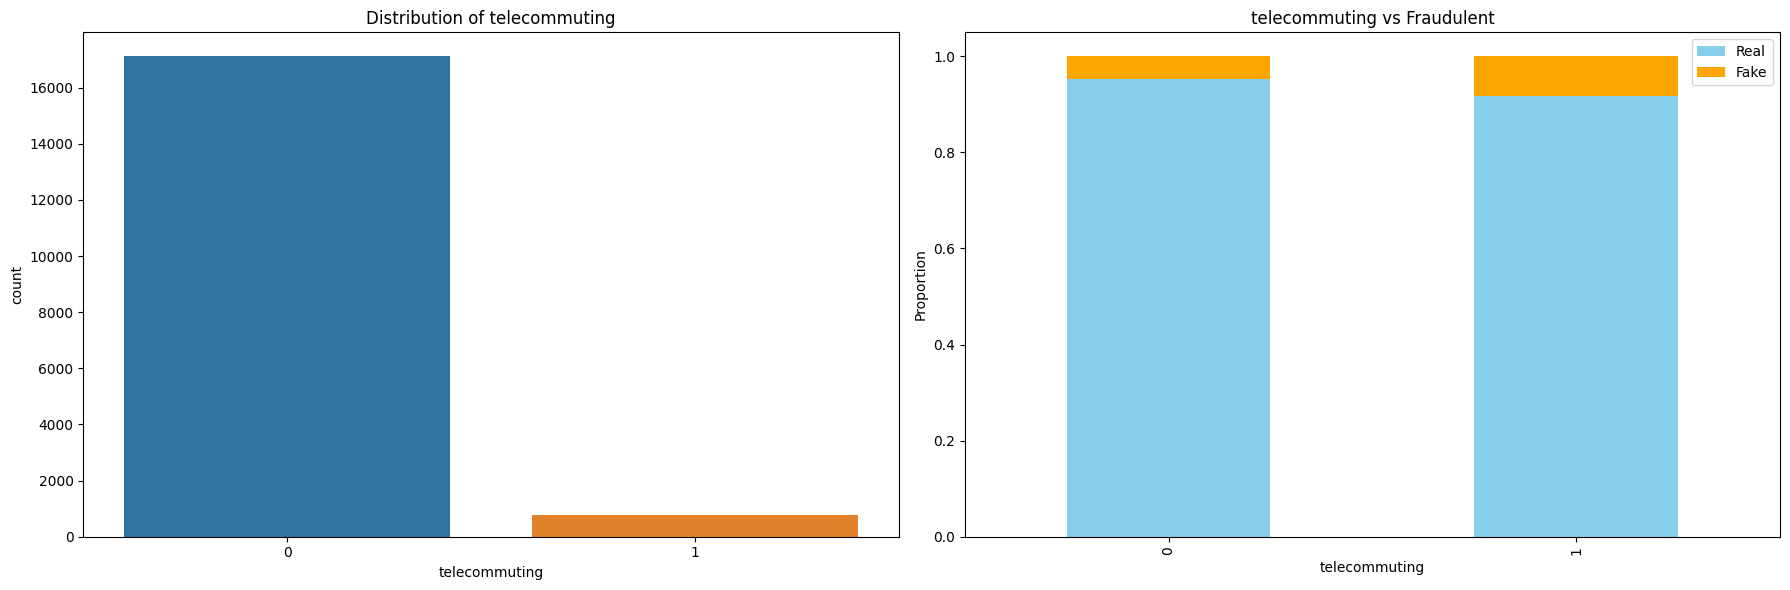

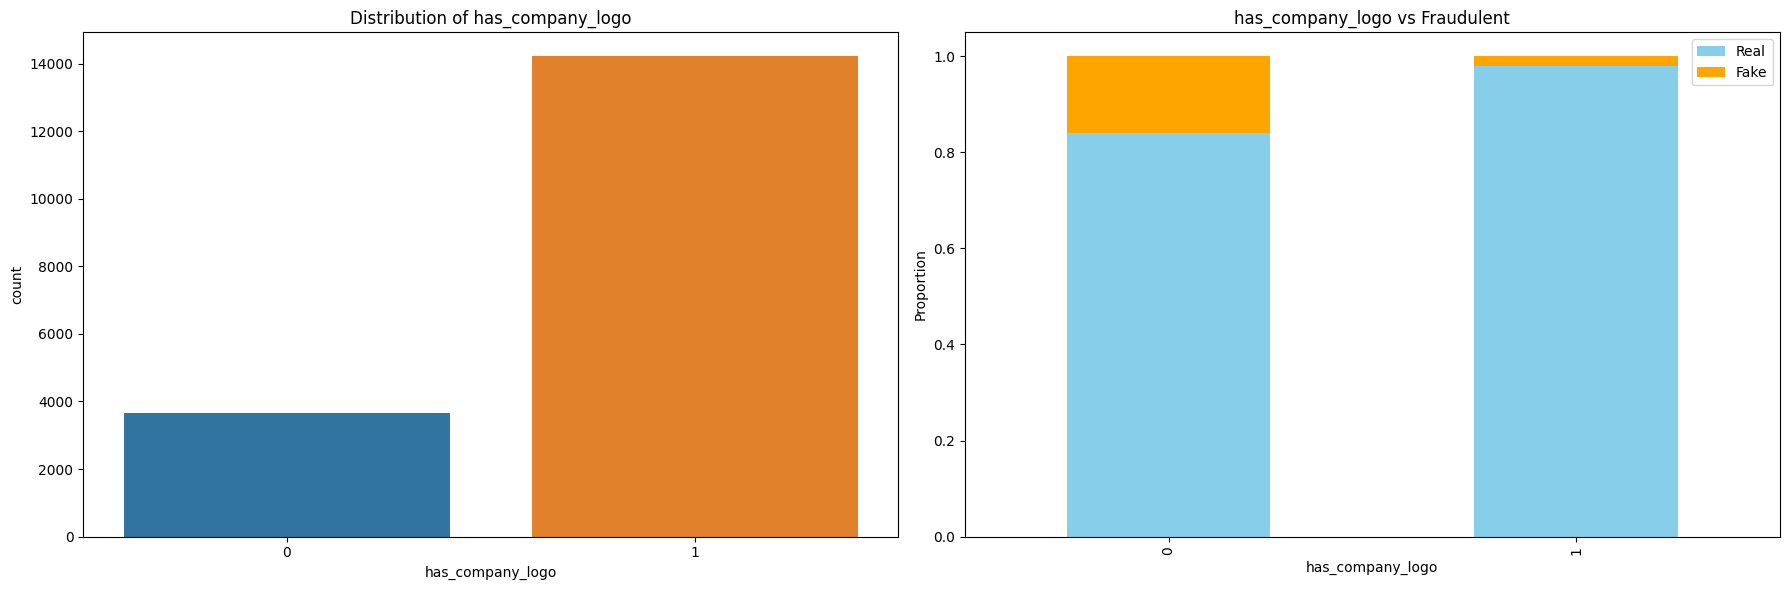

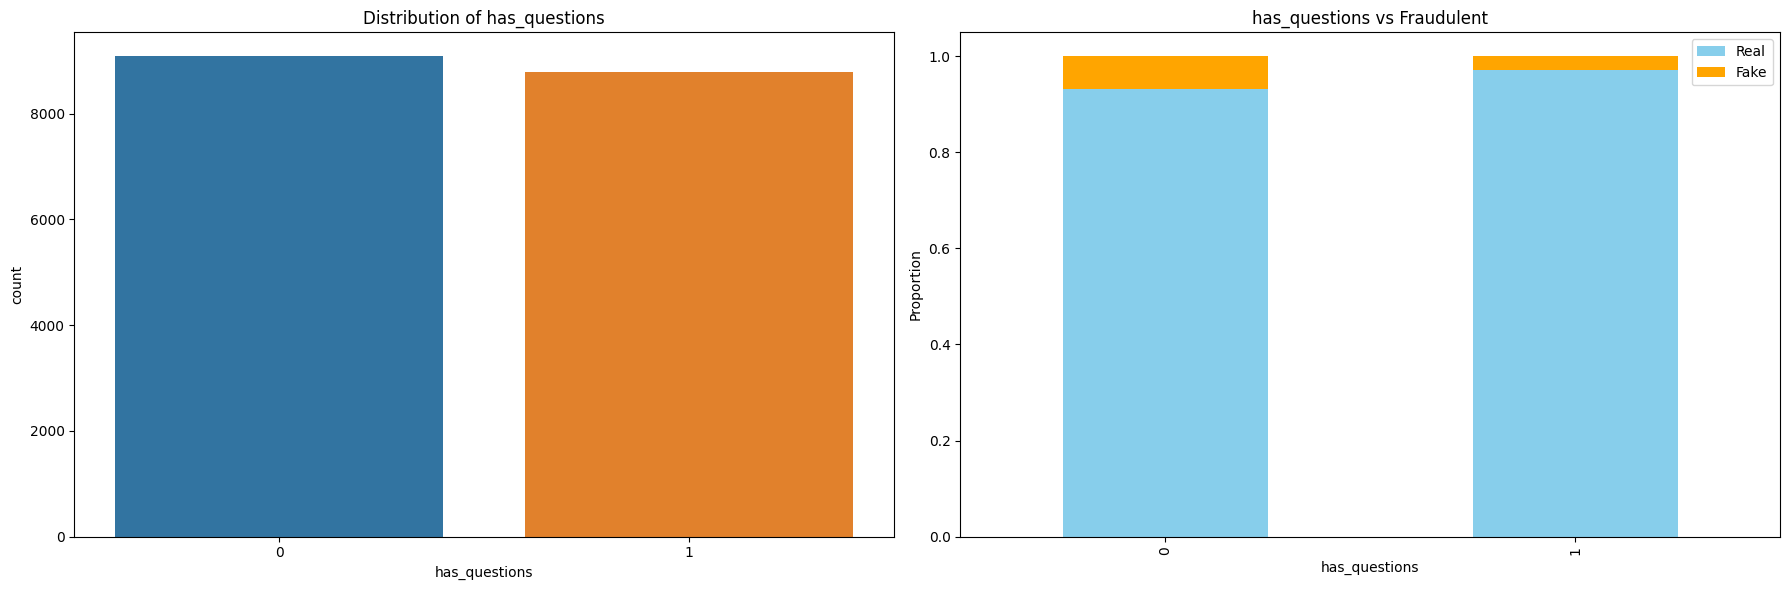

In [23]:
# Plot the distribution of numerical features
numerical_features = ['telecommuting', 'has_company_logo', 'has_questions']


for feature in numerical_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    
    sns.countplot(x=feature, data=data_original, ax=axes[0])
    axes[0].set_title(f'Distribution of {feature}')
    
    cross_tab = pd.crosstab(data_original[feature], data_original['fraudulent'])
    cross_tab_ratio = cross_tab.div(cross_tab.sum(1).astype(float), axis=0)
    cross_tab_ratio.plot(kind='bar', stacked=True, ax=axes[1], color=['skyblue', 'orange'])
    
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles, ['Real', 'Fake'])
    
    axes[1].set_title(f'{feature} vs Fraudulent')
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel('Proportion')
    
    plt.tight_layout()
    plt.show()


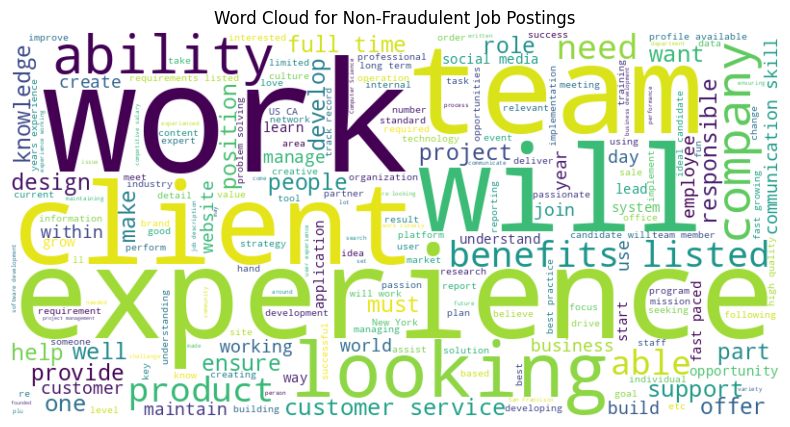

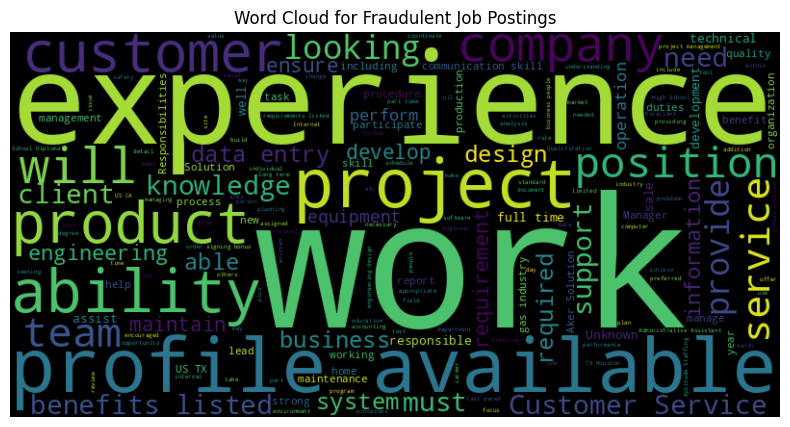

In [24]:

# Word cloud for non-fraudulent job postings
non_fraudulent_text = ' '.join(data_original[data_original['fraudulent'] == 0]['text'])
wordcloud_non_fraudulent = WordCloud(width=800, height=400, background_color='white').generate(non_fraudulent_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_fraudulent, interpolation='bilinear')
plt.title('Word Cloud for Non-Fraudulent Job Postings')
plt.axis('off')
plt.show()

# Word cloud for fraudulent job postings
fraudulent_text = ' '.join(data_original[data_original['fraudulent'] == 1]['text'])
wordcloud_fraudulent = WordCloud(width=800, height=400, background_color='black').generate(fraudulent_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fraudulent, interpolation='bilinear')
plt.title('Word Cloud for Fraudulent Job Postings')
plt.axis('off')
plt.show()


## Conclusion from EDA

### Imbalanced Dataset
- The dataset has a significant imbalance between real and fake job postings, which could impact model performance and requires handling (e.g., through resampling techniques like SMOTE).

### Distinct Patterns in Fake Job Postings
Fake job postings tend to have:
- Less specific employment types and required experiences.
- Lower educational requirements.
- Higher likelihood of lacking a company logo.
- Different word usage patterns in job descriptions, often focusing on more generic terms.

### Feature Importance for Classification
- The presence of a company logo and specific job functions/experience/education levels are important indicators of job posting authenticity.
- Text analysis of job descriptions reveals distinct patterns in fake job postings that can be leveraged for classification.

These insights provide a foundation for building models to detect fraudulent job postings, with a focus on handling class imbalance and leveraging both categorical and text features.


# Data Preprocessing

In [25]:
# Issues to tackle with our text

# \xa0http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 
#  at\xa0#URL_395a8683a907ce95f49a12fb240e6e47ad8d5a4f96d07ebbd869c4dd4dea1826#\xa0and
# \xa0After
# \xa0Valor
# opportunitiesLeverage

In [26]:
 #url_395a8683a907ce95f49a12fb240e6e47ad8d5a4f96d07ebbd869c4dd4dea1826#
# |  |  organised - focused - vibrant - awesomedo
 #nz n auckland

In [27]:
import re

In [28]:
def clean_text(text):
    text = re.sub(r'\\n', ' ', text)  # Remove newline characters
    text = re.sub(r'\\', '', text)  # Remove backslashes
    text = re.sub(r'\.{3}', '', text)  # Remove ellipses
    text = re.sub(r'[".,:!]', '', text)  # Remove specific punctuation marks
    text = re.sub(r"(?<!\w)\'|\'(?!\w)", '', text)  # Remove apostrophes that are not part of a word
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text


In [29]:
def preprocess_text(text):
    text = text.lower()  # lowercase the text
    return text

In [30]:

def remove_urls(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'#url_[\w\d]+#', '', text, flags=re.IGNORECASE)  # Remove custom URL patterns
    return text


In [31]:
def remove_special_chars(text):
    text = re.sub(r'\xa0', ' ', text)  # Replace non-breaking space with a regular space
    text = re.sub(r'#\s*\|\s*\|', '', text)  # Remove patterns like '# | | '
    return text


In [32]:
def separate_concatenated_words(text):
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  # Separate words with CamelCase pattern
    text = re.sub(r'([a-z])([0-9])', r'\1 \2', text)  # Separate words with letters and numbers
    text = re.sub(r'([0-9])([a-z])', r'\1 \2', text)  # Separate numbers and letters
    text = re.sub(r'([A-Z]{2,})([a-z])', lambda m: ' '.join(m.group(0)), text)  # Handle cases like "NZNAuckland"
    return text



In [33]:
def full_preprocess(text):
    text = clean_text(text)
    text = preprocess_text(text)
    text = remove_urls(text)
    text = remove_special_chars(text)
    text = separate_concatenated_words(text)
    return text



In [34]:
data['text'] = data['text'].apply(full_preprocess)

In [35]:
data.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,1,0,2,4,9,123,22,0,marketing intern us ny new york marketing we'r...
1,0,1,0,1,6,9,75,7,0,customer service - cloud video production nz a...
2,0,1,0,1,6,9,123,36,0,commissioning machinery assistant (cma) us ia ...
3,0,1,0,1,5,1,22,31,0,account executive - washington dc us dc washin...
4,0,1,1,1,5,1,51,16,0,bill review manager us fl fort worth unknown s...


# Feature Extraction

In [36]:
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


In [37]:
nltk.download('punkt')
data['tokens'] = data['text'].apply(word_tokenize)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
model = Word2Vec(sentences=data['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [39]:
def get_text_vector(tokens):
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    vector = np.mean([model.wv[word] for word in valid_tokens], axis=0)
    return vector


In [40]:
data['vector'] = data['tokens'].apply(get_text_vector)

In [41]:
data.head(1)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text,tokens,vector
0,0,1,0,2,4,9,123,22,0,marketing intern us ny new york marketing we'r...,"[marketing, intern, us, ny, new, york, marketi...","[-0.008835654, 0.87501353, -0.5045617, -0.5701..."


# Train Test Split

In [42]:
# From our EDA we can observe that there is a high imbalance in the given dataset.
# Let's solve that use SMOTE before train test split

In [43]:
data['fraudulent'].value_counts()

fraudulent
0    17014
1      865
Name: count, dtype: int64

In [44]:
# There is a huge difference between the value_counts of 1 and 0

In [45]:
X = data.drop(['fraudulent','text', 'tokens'],axis='columns')
Y = data['fraudulent']

In [46]:
X.shape

(17879, 9)

In [47]:
from sklearn.preprocessing import MinMaxScaler


In [48]:
# Scale the values for better model performance
scaler = MinMaxScaler()
columns_to_normalize = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])


In [49]:
X.head(2)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,vector
0,0,1,0,0.50,0.666667,0.75,0.938931,0.594595,"[-0.008835654, 0.87501353, -0.5045617, -0.5701..."
1,0,1,0,0.25,1.000000,0.75,0.572519,0.189189,"[-0.17737664, 1.0349935, -1.1535225, -0.514889..."


In [50]:
# Convert features to numpy arrays
X_vector = np.array(X['vector'].tolist())
X_other = X.drop(columns=['vector']).to_numpy()

# Combine all features
X_combined = np.hstack((X_other, X_vector))


In [51]:
X.shape

(17879, 9)

In [52]:
X_combined.shape

(17879, 108)

In [53]:
from imblearn.over_sampling import SMOTE


In [54]:
# Ensure all data is in numerical format
X_combined = X_combined.astype(float)


In [55]:
# Resample using SMOTE
smote = SMOTE(sampling_strategy={1: 17014}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined,Y)


In [56]:
y_resampled.value_counts()

fraudulent
0    17014
1    17014
Name: count, dtype: int64

In [57]:
# Now the dataset is balanced 

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    

# Model Building

# ANN

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Flatten ,Bidirectional , BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


2024-06-04 11:25:42.306176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 11:25:42.306340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 11:25:42.476276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [60]:
input_dim = X_train.shape[1]

In [61]:
input_dim

108

In [62]:
ann_model = Sequential()
ann_model.add(Dense(128, input_dim=input_dim, activation='relu'))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(1, activation='sigmoid'))
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        13,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,273 (87.00 KB)

 Trainable params: 22,273 (87.00 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
ann_history = ann_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7374 - loss: 0.5082 - val_accuracy: 0.8843 - val_loss: 0.2751
Epoch 2/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8974 - loss: 0.2629 - val_accuracy: 0.9190 - val_loss: 0.2090
Epoch 3/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9249 - loss: 0.1969 - val_accuracy: 0.9418 - val_loss: 0.1562
Epoch 4/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9358 - loss: 0.1730 - val_accuracy: 0.9467 - val_loss: 0.1378
Epoch 5/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9400 - loss: 0.1554 - val_accuracy: 0.9504 - val_loss: 0.1241
Epoch 6/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9507 - loss: 0.1380 - val_accuracy: 0.9568 - val_loss: 0.1068
Epoch 7/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9527 - loss: 0.1302 - val_accuracy: 0.9570 - val_loss: 0.1042
Epoch 8/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9552 - loss: 0.1210 - val_accuracy: 0.

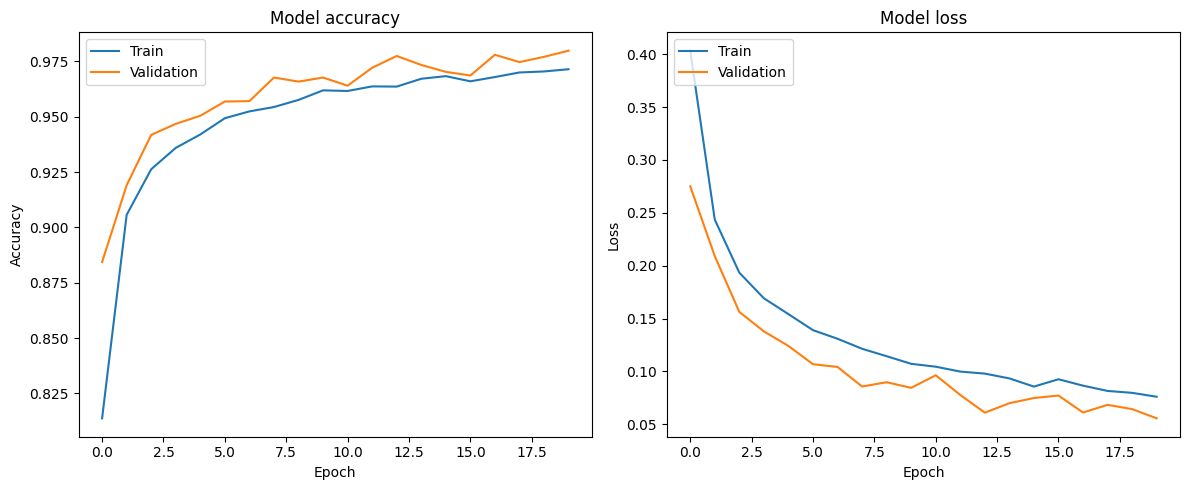

In [64]:
plot_graph(ann_history)

# LSTM Model

In [65]:
# Reshape data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])


In [66]:
(X_train_lstm.shape[1], X_train_lstm.shape[2])

(1, 108)

In [67]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        44,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,737 (221.63 KB)

 Trainable params: 56,737 (221.63 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Create and train the LSTM model
lstm_history= lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7964 - loss: 0.4243 - val_accuracy: 0.9045 - val_loss: 0.2496
Epoch 2/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9131 - loss: 0.2222 - val_accuracy: 0.9295 - val_loss: 0.1902
Epoch 3/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9352 - loss: 0.1715 - val_accuracy: 0.9416 - val_loss: 0.1544
Epoch 4/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9453 - loss: 0.1390 - val_accuracy: 0.9460 - val_loss: 0.1384
Epoch 5/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9566 - loss: 0.1143 - val_accuracy: 0.9291 - val_loss: 0.1714
Epoch 6/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9632 - loss: 0.1011 - val_accuracy: 0.9635 - val_loss: 0.1035
Epoch 7/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9693 - loss: 0.0830 - val_accuracy: 0.9691 - val_loss: 0.0872
Epoch 8/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9758 - loss: 0.0670 - val_accuracy: 0.

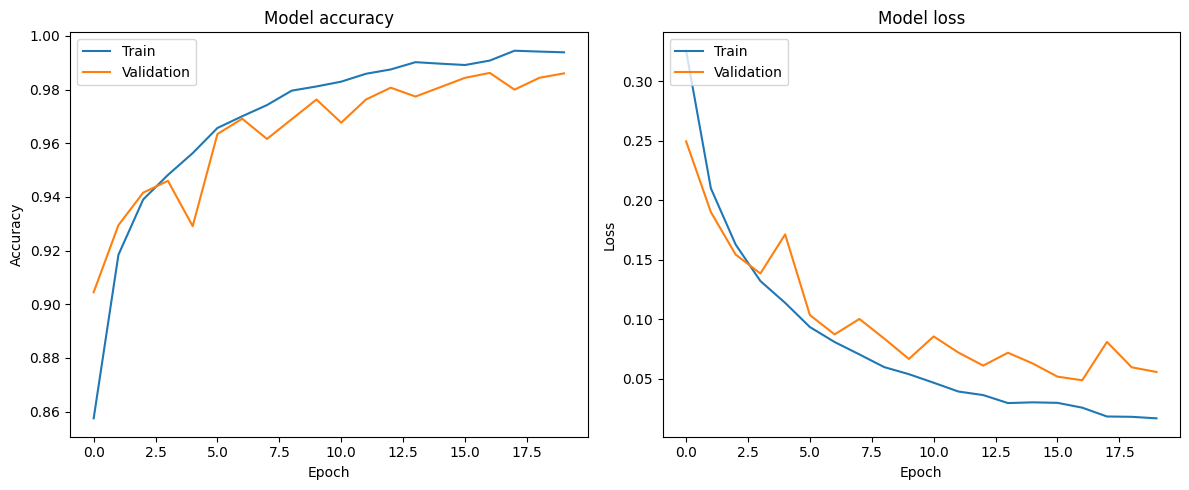

In [69]:
plot_graph(lstm_history)

# CNN

In [74]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Reshape data for CNN
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [75]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 106, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 53, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 51, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,281 (130.00 KB)

 Trainable params: 33,281 (130.00 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7165 - loss: 0.5330 - val_accuracy: 0.8911 - val_loss: 0.2785
Epoch 2/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9025 - loss: 0.2613 - val_accuracy: 0.8951 - val_loss: 0.2540
Epoch 3/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9243 - loss: 0.2019 - val_accuracy: 0.9247 - val_loss: 0.1903
Epoch 4/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9335 - loss: 0.1782 - val_accuracy: 0.9234 - val_loss: 0.1898
Epoch 5/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9464 - loss: 0.1486 - val_accuracy: 0.9464 - val_loss: 0.1323
Epoch 6/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9587 - loss: 0.1187 - val_accuracy: 0.9502 - val_loss: 0.1254
Epoch 7/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9588 - loss: 0.1158 - val_accuracy: 0.9666 - val_loss: 0.0918
Epoch 8/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9680 - loss: 0.0912 - val_accu

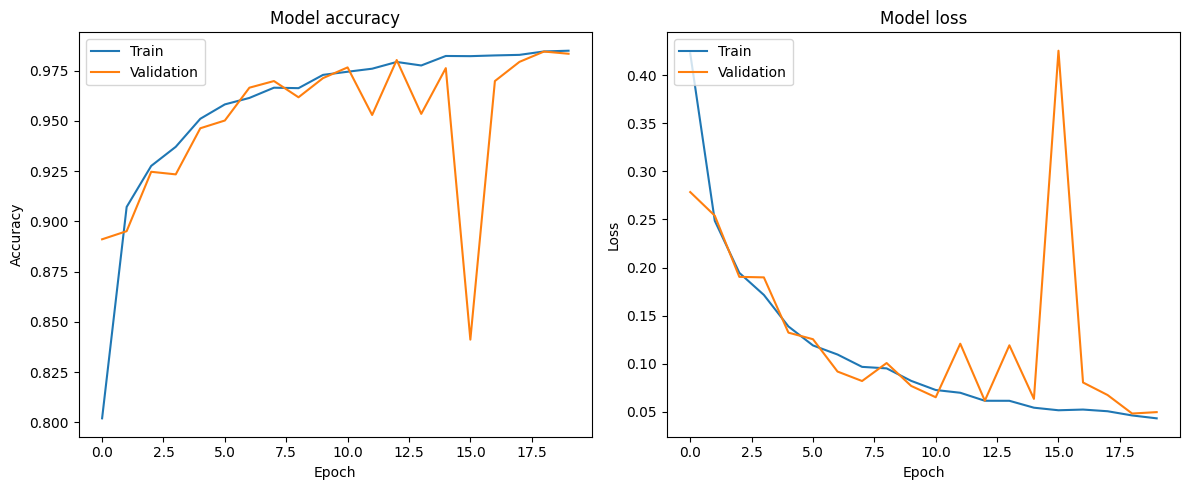

In [77]:
plot_graph(cnn_history)


# BiLSTM

In [78]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=input_shape)))
bilstm_model.add(Bidirectional(LSTM(32)))
bilstm_model.add(Dense(64, activation='relu'))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(1, activation='sigmoid'))
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bilstm_model.summary()




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [79]:
bilstm_history = bilstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8033 - loss: 0.4206 - val_accuracy: 0.9076 - val_loss: 0.2251
Epoch 2/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9161 - loss: 0.2098 - val_accuracy: 0.9095 - val_loss: 0.2150
Epoch 3/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9356 - loss: 0.1654 - val_accuracy: 0.9447 - val_loss: 0.1390
Epoch 4/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9510 - loss: 0.1261 - val_accuracy: 0.9467 - val_loss: 0.1399
Epoch 5/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9590 - loss: 0.1112 - val_accuracy: 0.9585 - val_loss: 0.1080
Epoch 6/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9681 - loss: 0.0878 - val_accuracy: 0.9535 - val_loss: 0.1149
Epoch 7/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9722 - loss: 0.0763 - val_accuracy: 0.9526 - val_loss: 0.1293
Epoch 8/20
681/681 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9768 - loss: 0.0649 - val_accuracy: 0

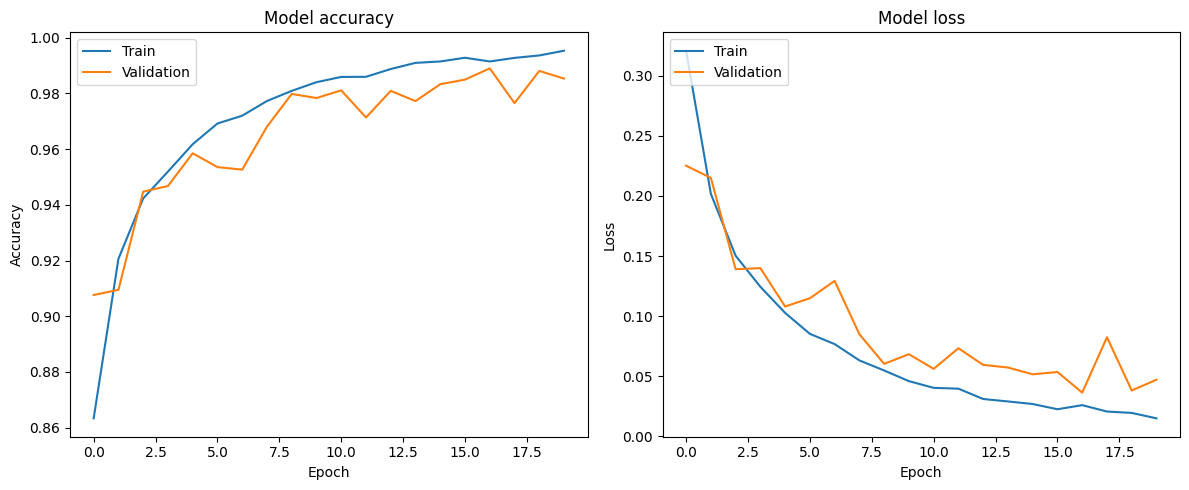

In [80]:
plot_graph(bilstm_history)


# Evalution

In [82]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [83]:

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label') 
    plt.show()


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9788 - loss: 0.0626
ANN Model - Loss: 0.05809082090854645, Accuracy: 0.979576826095581
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


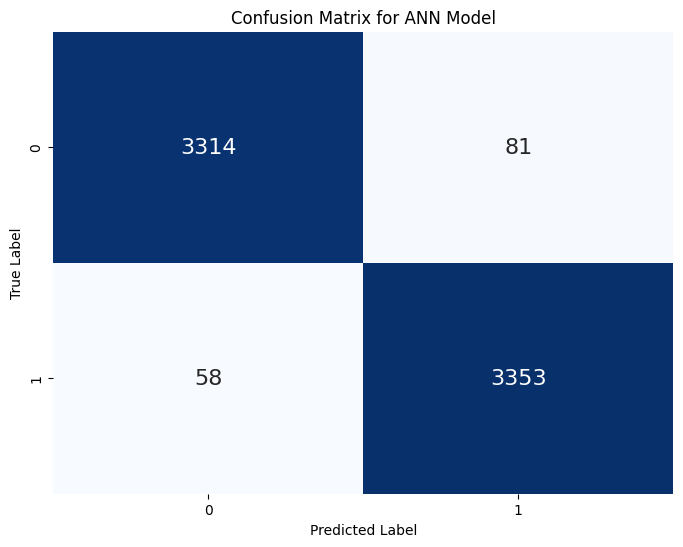

In [84]:
# Evaluate the ANN model
ann_loss, ann_accuracy = ann_model.evaluate(X_test, y_test)
print(f'ANN Model - Loss: {ann_loss}, Accuracy: {ann_accuracy}')

# Predictions for ANN
y_pred_ann = ann_model.predict(X_test)
y_pred_ann = (y_pred_ann > 0.5).astype(int)

# Confusion Matrix for ANN
cm_ann = confusion_matrix(y_test, y_pred_ann)
plot_confusion_matrix(cm_ann, title='Confusion Matrix for ANN Model')


In [85]:

# Print classification reports
print("Classification Report for ANN Model:")
print(classification_report(y_test, y_pred_ann))


Classification Report for ANN Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3395
           1       0.98      0.98      0.98      3411

    accuracy                           0.98      6806
   macro avg       0.98      0.98      0.98      6806
weighted avg       0.98      0.98      0.98      6806



213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0529
LSTM Model - Loss: 0.04982905462384224, Accuracy: 0.9876579642295837
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


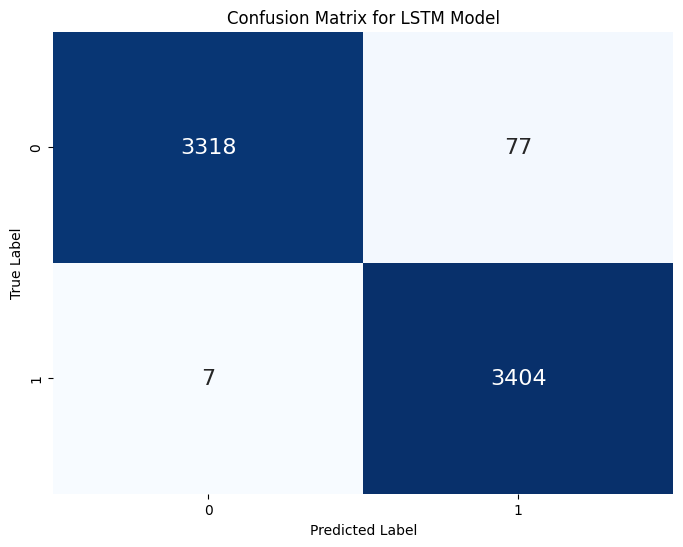

In [86]:
# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print(f'LSTM Model - Loss: {lstm_loss}, Accuracy: {lstm_accuracy}')

# Predictions for LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)



# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plot_confusion_matrix(cm_lstm, title='Confusion Matrix for LSTM Model')


In [87]:

print("Classification Report for LSTM Model:")
print(classification_report(y_test, y_pred_lstm))


Classification Report for LSTM Model:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3395
           1       0.98      1.00      0.99      3411

    accuracy                           0.99      6806
   macro avg       0.99      0.99      0.99      6806
weighted avg       0.99      0.99      0.99      6806



213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9782 - loss: 0.0646
CNN Model - Loss: 0.05754591524600983, Accuracy: 0.9803115129470825
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


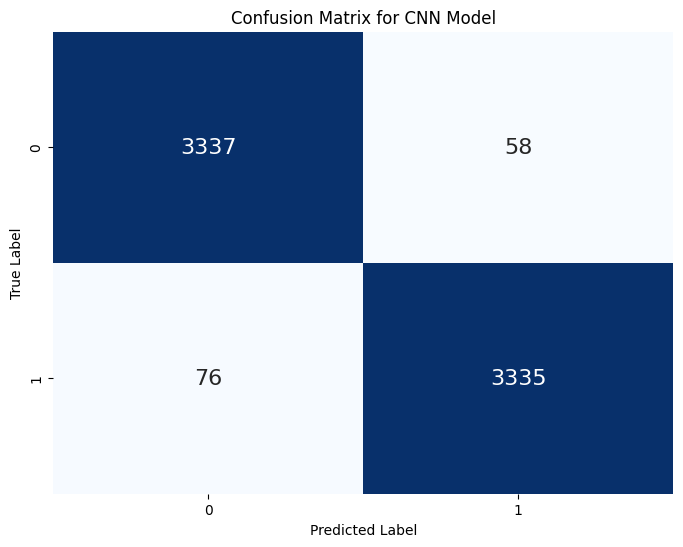

In [88]:

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f'CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}')

y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plot_confusion_matrix(cm_cnn, title='Confusion Matrix for CNN Model')



In [89]:
print("Classification Report for CNN Model:")
print(classification_report(y_test, y_pred_cnn))


Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3395
           1       0.98      0.98      0.98      3411

    accuracy                           0.98      6806
   macro avg       0.98      0.98      0.98      6806
weighted avg       0.98      0.98      0.98      6806



213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9858 - loss: 0.0569
BiLSTM Model - Loss: 0.04874236881732941, Accuracy: 0.9882456660270691
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


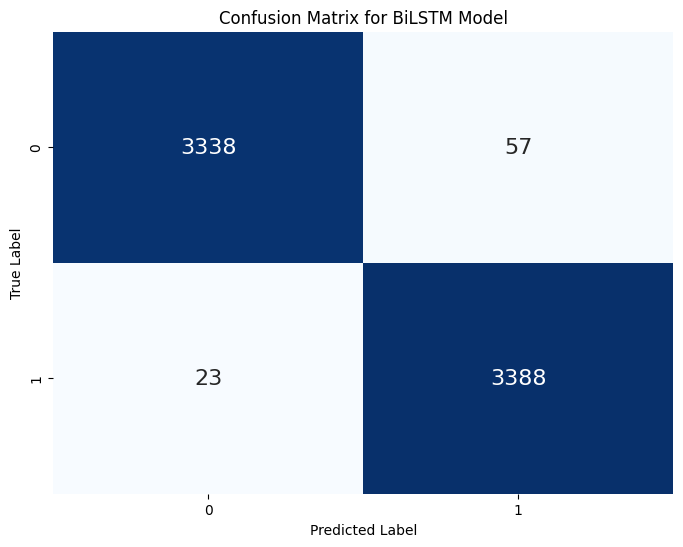

In [90]:
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test_lstm, y_test)
print(f'BiLSTM Model - Loss: {bilstm_loss}, Accuracy: {bilstm_accuracy}')

y_pred_bilstm = bilstm_model.predict(X_test_lstm)
y_pred_bilstm = (y_pred_bilstm > 0.5).astype(int)
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)
plot_confusion_matrix(cm_bilstm, title='Confusion Matrix for BiLSTM Model')


In [91]:
print("Classification Report for BiLSTM Model:")
print(classification_report(y_test, y_pred_bilstm))


Classification Report for BiLSTM Model:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3395
           1       0.98      0.99      0.99      3411

    accuracy                           0.99      6806
   macro avg       0.99      0.99      0.99      6806
weighted avg       0.99      0.99      0.99      6806



# Conclusions

#### Artificial Neural Network (ANN)
- **Architecture:** Implemented a neural network with two hidden layers, utilizing dropout for regularization.
- **Performance:**
  - **Accuracy:** The ANN model achieved an accuracy of approximately 97.96% on the test set.
  - **Loss:** The model showed good convergence with a loss value of 0.0581.
  - **Classification Report:** The model demonstrated high precision, recall, and F1-score (all approximately 0.98), effectively handling both classes.

#### Long Short-Term Memory (LSTM) Model
- **Architecture:** Developed an LSTM model to capture sequential dependencies in the data.
- **Performance:**
  - **Accuracy:** The LSTM model achieved an accuracy of approximately 98.77% on the test set.
  - **Loss:** The model showed excellent convergence with a low loss value of 0.0498.
  - **Classification Report:** The model demonstrated high precision, recall, and F1-score (approximately 0.99), effectively handling both classes.

#### Convolutional Neural Network (CNN)
- **Architecture:** Built a CNN model to extract spatial features from the data.
- **Performance:**
  - **Accuracy:** The CNN model achieved an accuracy of approximately 98.03% on the test set.
  - **Loss:** The model showed good convergence with a loss value of 0.0575.
  - **Classification Report:** The model demonstrated high precision, recall, and F1-score (all approximately 0.98), effectively handling both classes.

#### Bidirectional Long Short-Term Memory (BiLSTM) Model
- **Architecture:** Developed a BiLSTM model to capture bidirectional sequential dependencies in the data.
- **Performance:**
  - **Accuracy:** The BiLSTM model achieved the highest accuracy of approximately 98.82% on the test set.
  - **Loss:** The model showed excellent convergence with a low loss value of 0.0487.
  - **Classification Report:** The model demonstrated high precision, recall, and F1-score (approximately 0.99), effectively handling both classes.



### Overall Findings
- **Model Comparison:** All models performed exceptionally well, with the BiLSTM model slightly outperforming the others. This can be attributed to its ability to capture bidirectional sequential dependencies in the data.
- **Accuracy:** The BiLSTM model achieved the highest accuracy at 98.82%, followed by the LSTM model at 98.77%, CNN at 98.03%, and ANN at 97.96%.
- **Loss:** The BiLSTM model had the lowest loss at 0.0487, indicating better model convergence.
- **Classification Report:** All models showed high precision, recall, and F1-scores, indicating effective classification of both classes.

While all models demonstrated strong performance in detecting patterns within the data, the BiLSTM model's superior ability to capture and leverage bidirectional dependencies resulted in the highest accuracy and best overall performance. This suggests that for this particular dataset and task, models that can capture sequential patterns in both forward and backward directions offer a significant advantage.
